In [ ]:
import torch
import torch.nn as nn 
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn.functional as F
import math
import os
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import datetime
from typing import Union
from pathlib import Path

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ausdata.csv')

series = df['SYSLoad']
series_2 = df['Date']


In [ ]:
def get_indices_entire_sequence(data: pd.DataFrame, window_size: int, step_size: int) -> list:

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices


In [ ]:
def read_data(data_dir: Union[str, Path] = "data",  
    timestamp_col_name: str="timestamp") -> pd.DataFrame:

    # Ensure that `data_dir` is a Path object
    data_dir = Path(data_dir)

    # Read csv file
    csv_files = list(data_dir.glob("*.csv"))
    
    if len(csv_files) > 1:
        raise ValueError("data_dir contains more than 1 csv file. Must only contain 1")
    elif len(csv_files) == 0:
	      raise ValueError("data_dir must contain at least 1 csv file.")

    data_path = csv_files[0]

    print("Reading file in {}".format(data_path))

    data = pd.read_csv(
        data_path, 
        parse_dates=[timestamp_col_name], 
        index_col=[timestamp_col_name], 
        infer_datetime_format=True,
        low_memory=False
    )


    data.sort_values(by=[timestamp_col_name], inplace=True)

    return data

In [ ]:
data_dir='/content/drive/MyDrive/ausdata.csv'

In [ ]:
mydata = pd.read_csv(data_dir)

In [ ]:
main_dir='/content/drive/My Drive/thesis/preprocess/'
src_dir = os.path.join(main_dir , 'sampled')
if(not os.path.isdir(src_dir)):
    os.makedirs(src_dir)
mydata.to_csv(os.path.join(src_dir, 'NSW.csv'))  

In [ ]:
#create date-time column in dataframe

mydata['Date']=mydata['Date'].astype(str)                     # concatenate date and hour  
mydata['Date'] = pd.to_datetime(mydata['Date'], infer_datetime_format = True)            # change to datetime type 
mydata

,Date,Hour,DryBulb,DewPnt,WetBulb,Humidity,ElecPrice,SYSLoad
0,2006-01-01,0.5,23.90,21.65,22.40,87.5,19.67,8013.27833
1,2006-01-01,1.0,23.90,21.70,22.40,88.0,18.56,7726.89167
2,2006-01-01,1.5,23.80,21.65,22.35,88.0,19.09,7372.85833
3,2006-01-01,2.0,23.70,21.60,22.30,88.0,17.40,7071.83333
4,2006-01-01,2.5,23.70,21.60,22.30,88.0,17.00,6865.44000
...,...,...,...,...,...,...,...,...
87643,2010-12-31,22.0,22.60,19.10,20.40,81.0,23.86,8449.54000
87644,2010-12-31,22.5,22.45,19.05,20.30,81.5,26.49,8508.16000
87645,2010-12-31,23.0,22.30,19.00,20.20,82.0,25.18,8413.14000
87646,2010-12-31,23.5,22.05,19.05,20.15,83.5,26.19,8173.79000


In [ ]:
data = read_data(src_dir,timestamp_col_name="Date")

Reading file in /content/drive/My Drive/thesis/preprocess/sampled/NSW.csv


In [ ]:
#normalization


nb_time = len(data)
nb_val = int(nb_time*0.8)

train, test = data[:nb_val], data[nb_val:]

scaler_E=StandardScaler() 

E_train_scaled=scaler_E.fit_transform(train.SYSLoad.values.reshape(-1, 1))   #E is the same as SYSLoad
E_test_scaled=scaler_E.transform(test.SYSLoad.values.reshape(-1, 1))

data['SYSLoad']=np.concatenate((E_train_scaled,E_test_scaled), axis=0)

data.to_csv(os.path.join(src_dir, 'NSW.csv'))  

In [ ]:
class Dataset_generator(Dataset):

    def __init__(self, 
        #myscaler:any,         
        data: torch.tensor,
        indices: list, 
        input_seq_len: int, 
        output_seq_len: int
        ) -> None:


        
        super().__init__()

      

        self.indices = indices

        self.data = data



        self.input_seq_len = input_seq_len



        self.output_seq_len = output_seq_len



    def __len__(self):
        
        return len(self.indices)

    def __getitem__(self, index):

        # Get the first element of the i'th tuple in the list self.indicesasdfas
        start_idx = self.indices[index][0]

        # Get the second (and last) element of the i'th tuple in the list self.indices
        end_idx = self.indices[index][1]

        sequence = self.data[start_idx:end_idx]

        

        

        src, trg = self.get_src_trg(
            
            sequence=sequence,
            input_seq_len=self.input_seq_len,
            output_seq_len=self.output_seq_len
            )
        
        return src, trg      
    
    def get_src_trg(
        self,
        sequence: torch.Tensor, 
        input_seq_len: int, 
        output_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor]:
        


        assert len(sequence) == input_seq_len + output_seq_len, "Sequence length does not equal (input length + target length)"
        
        # encoder input
        src = sequence[:input_seq_len] 
        
        


        trg_y = sequence[-output_seq_len:]

        if len(trg_y.shape) == 1:  #new

           trg_y = trg_y.unsqueeze(-1)          #new

        assert len(trg_y) == output_seq_len, "Length of trg_y does not match target sequence length"

        return src.unsqueeze(-1),trg_y   #.squeeze(-1) # change size from [batch_size, output_seq_len, num_features] to [batch_size, output_seq_len] 


In [ ]:
# change it based on your dataset
training_data = data[:nb_val]    #80 % of dataset
validation_data = data[nb_val:int(nb_time*0.9)]   #20 % of dataset
test_data = data[int(nb_time*0.9):]    #20 % of dataset

In [ ]:
input_seq_len = 24  #input to model previous day 
output_sequence_length  = 6  #prediction horizon   
step_size = 1

window_size = input_seq_len + output_sequence_length

training_indices = get_indices_entire_sequence(
    data=training_data, 
    window_size=window_size, 
    step_size=step_size)

validation_indices = get_indices_entire_sequence(
    data=validation_data, 
    window_size=window_size, 
    step_size=step_size)

test_indices = get_indices_entire_sequence(
    data=test_data, 
    window_size=window_size, 
    step_size=step_size)

In [ ]:
batch_size = 1024 
# Making instance of custom dataset class
training_data = Dataset_generator(
    #myscaler=scaler_E,
    data=torch.tensor(training_data['SYSLoad'].values).float(),
    indices=training_indices,
    input_seq_len=input_seq_len,
    output_seq_len=output_sequence_length,
    )

validation_data = Dataset_generator(
    #myscaler=scaler_E,
    data=torch.tensor(validation_data['SYSLoad'].values).float(),
    indices=validation_indices,
    input_seq_len=input_seq_len,
    output_seq_len=output_sequence_length,
    )

test_data = Dataset_generator(
    #myscaler=scaler_E,
    data=torch.tensor(test_data['SYSLoad'].values).float(),
    indices=test_indices,
    input_seq_len=input_seq_len,
    output_seq_len=output_sequence_length,
    )

# Making dataloader
training_data_load = DataLoader(training_data, batch_size)
validation_data_load = DataLoader(validation_data, batch_size)
test_data_load = DataLoader(test_data, batch_size)

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()

    def forward(self, x):
      batch_size = x.size(0)
      seq_len = x.size(1)
      
      h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
      c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
      
      h_out, _ = self.lstm(x, (h0, c0))
      h_out = h_out[:, -1, :]  # Take the final hidden state from the last time step
      
      out = self.fc2(self.relu(self.fc1(h_out)))
      
      return out

In [ ]:
#LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,forecast_window):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = forecast_window
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -self.output_seq:, :])  # select the last 48 time steps and pass through fully connected layer
        # print(out.shape)
        
        return out

In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

forecast_window = 6
input_size = 1
num_layers = 2
output_size = 1
hidden_size = 100
model = LSTMModel(input_size, hidden_size, output_size, num_layers,forecast_window)
criterion = torch.nn.MSELoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)



In [ ]:
early_stopping_patience = 150
early_stopping_counter = 0

train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    
  model.train()

  for i , (input, output) in enumerate(training_data_load):
    input = input.to(device)
    output = output.to(device)
    optimizer.zero_grad()

    pred = model(input)
    loss_tr = criterion(output, pred)

    loss_tr.backward()

    optimizer.step()

  train_loss.append(loss_tr.item())

  model.eval()      
  with torch.no_grad():
    
    for i , (input, output) in enumerate(validation_data_load):
      input = input.to(device)
      output = output.to(device)

      pred = model(input)
      loss_val = criterion(output, pred)

    val_loss.append(loss_val.item())

    print(f'epoch {epoch} -->  train loss :{loss_tr.item()} , val loss : {loss_val.item()}')


epoch 0 -->  train loss :1.3587712049484253 , val loss : 1.4234429597854614
epoch 1 -->  train loss :1.1391297578811646 , val loss : 1.3654197454452515
epoch 2 -->  train loss :1.0570566654205322 , val loss : 1.2633832693099976
epoch 3 -->  train loss :1.0342320203781128 , val loss : 1.2372167110443115
epoch 4 -->  train loss :1.0154697895050049 , val loss : 1.1990132331848145
epoch 5 -->  train loss :1.0044333934783936 , val loss : 1.1802266836166382
epoch 6 -->  train loss :0.992623507976532 , val loss : 1.1760700941085815
epoch 7 -->  train loss :0.9791039228439331 , val loss : 1.1769187450408936
epoch 8 -->  train loss :0.9611927270889282 , val loss : 1.181187391281128
epoch 9 -->  train loss :0.9284940958023071 , val loss : 1.1918587684631348
epoch 10 -->  train loss :0.8270633220672607 , val loss : 1.1566897630691528
epoch 11 -->  train loss :0.695555567741394 , val loss : 1.0682176351547241
epoch 12 -->  train loss :0.6655761003494263 , val loss : 0.9726250171661377
epoch 13 -->

Text(0, 0.5, 'Loss')

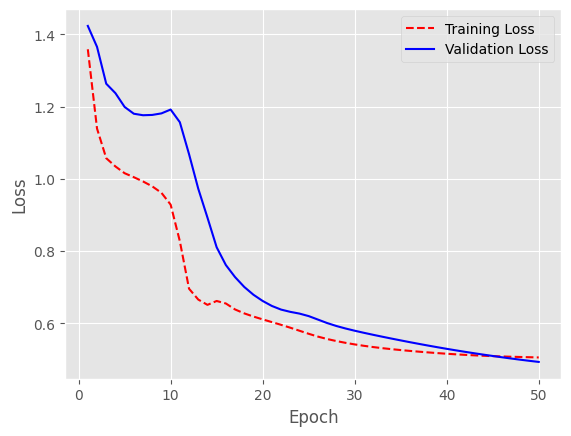

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import tqdm
plt.style.use('ggplot')
#from torchmetrics import MeanAbsolutePercentageError
  # visualization
  #  Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.clf()
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss','Validation Loss']) #, ['test Loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig(plots_file)

In [ ]:
#RMSE MAPE
def RMSE(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))

def MAPE(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets)*100)

In [ ]:
for i , (input, output) in enumerate(validation_data_load):
  input = input.to(device)
  output = output.to(device)

In [ ]:
#for test set
RMSE_result_test=[]
MAPE_result_test=[]

model.to(device)
model.eval()
with torch.no_grad():
  for i, (input ,output) in enumerate(validation_data_load):   # validation_dataloader

    
      input=input.to(device)
      output=output.to(device)
     

      prediction = model(input)

      #use inverse of scaler that we used for normalization for both y_true and prediction
      prediction=scaler_E.inverse_transform(prediction.detach().cpu().numpy().squeeze(-1))
      prediction=torch.tensor(prediction)
      prediction=prediction.unsqueeze(-1).to(device)

      output=scaler_E.inverse_transform(output.detach().cpu().numpy().squeeze(-1))
      output=torch.tensor(output)
      output=output.unsqueeze(-1).to(device)

      #loss_test = torch.sqrt(criterion(tgt_y, prediction))
      RMSE_test = RMSE(prediction,output)
      MAPE_test = MAPE(prediction,output)

      RMSE_result_test.append(RMSE_test.item())
      MAPE_result_test.append(MAPE_test.item())

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
RMSE_avg=Average(RMSE_result_test)
MAPE_avg= Average(MAPE_result_test)

In [ ]:
print('The mean square error is: %f' % RMSE_avg)
print('MAPE is: %f' % MAPE_avg)

The mean square error is: 916.838311
MAPE is: 7.907465


In [ ]:
predictions=np.array(prediction.detach().cpu().numpy())

In [ ]:
outputs = np.array(output.detach().cpu().numpy())

In [ ]:
pred = predictions[:,-1,:]
out = outputs[:,-1,:]

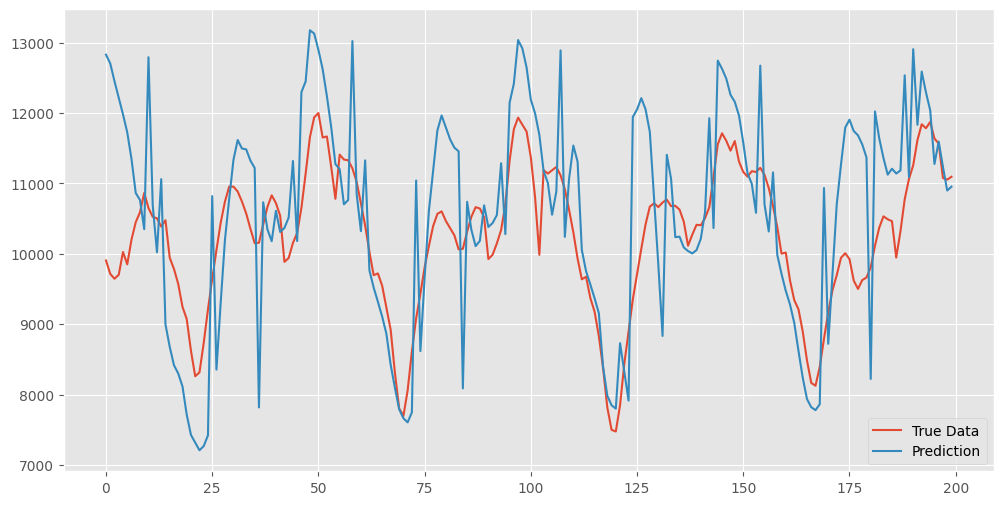

In [ ]:
fig = plt.figure(facecolor='white', figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(pred[-200:], label='True Data')
plt.plot(out[-200:], label='Prediction')
plt.legend()
plt.show()

In [ ]:
##RNN Model

In [ ]:
import torch
import torch.nn as nn

class RNNNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size, 40)
        self.fc2 = nn.Linear(40, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        h_out, _ = self.rnn(x, h0)
        h_out = h_out[:, -1, :]  # Take the final hidden state from the last time step
        
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, forecast_window):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = forecast_window
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -self.output_seq:, :])  # select the last 48 time steps and pass through fully connected layer
        
        return out


In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

forecast_window = 6
input_size = 1
num_layers = 2
output_size = 1
hidden_size = 100
model = RNNModel(input_size, hidden_size, output_size, num_layers,forecast_window)
criterion = torch.nn.MSELoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
early_stopping_patience = 150
early_stopping_counter = 0

train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    
  model.train()

  for i , (input, output) in enumerate(training_data_load):
    input = input.to(device)
    output = output.to(device)
    optimizer.zero_grad()

    pred = model(input)
    loss_tr = criterion(output, pred)

    loss_tr.backward()

    optimizer.step()

  train_loss.append(loss_tr.item())

  model.eval()      
  with torch.no_grad():
    
    for i , (input, output) in enumerate(validation_data_load):
      input = input.to(device)
      output = output.to(device)

      pred = model(input)
      loss_val = criterion(output, pred)

    val_loss.append(loss_val.item())

    print(f'epoch {epoch} -->  train loss :{loss_tr.item()} , val loss : {loss_val.item()}')


epoch 0 -->  train loss :0.9310974478721619 , val loss : 1.1825618743896484
epoch 1 -->  train loss :0.9187009930610657 , val loss : 1.1489880084991455
epoch 2 -->  train loss :0.9099087119102478 , val loss : 1.132152795791626
epoch 3 -->  train loss :0.9028280973434448 , val loss : 1.1225072145462036
epoch 4 -->  train loss :0.896676242351532 , val loss : 1.115863561630249
epoch 5 -->  train loss :0.8903228640556335 , val loss : 1.1103280782699585
epoch 6 -->  train loss :0.878846287727356 , val loss : 1.1041804552078247
epoch 7 -->  train loss :0.8194456696510315 , val loss : 1.1100748777389526
epoch 8 -->  train loss :0.7746838331222534 , val loss : 1.09982430934906
epoch 9 -->  train loss :0.7430392503738403 , val loss : 1.046656608581543
epoch 10 -->  train loss :0.6996056437492371 , val loss : 1.0112929344177246
epoch 11 -->  train loss :0.6696808338165283 , val loss : 0.9832298159599304
epoch 12 -->  train loss :0.6558532118797302 , val loss : 0.9569981098175049
epoch 13 -->  tr

Text(0, 0.5, 'Loss')

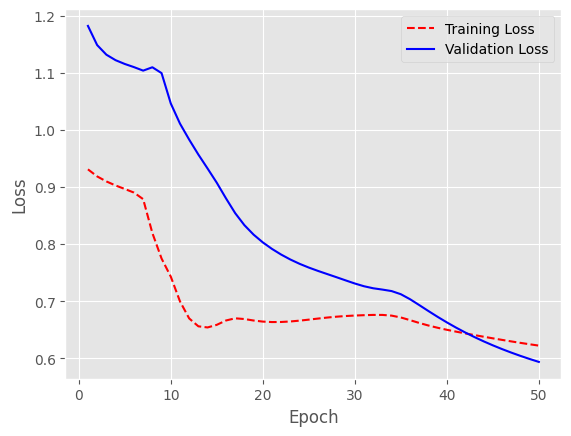

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import tqdm
plt.style.use('ggplot')
#from torchmetrics import MeanAbsolutePercentageError
  # visualization
  #  Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.clf()
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss','Validation Loss']) #, ['test Loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig(plots_file)

In [ ]:
#RMSE MAPE
def RMSE(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))

def MAPE(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets)*100)

In [ ]:
for i , (input, output) in enumerate(validation_data_load):
  input = input.to(device)
  output = output.to(device)

In [ ]:
#for test set
RMSE_result_test=[]
MAPE_result_test=[]

model.to(device)
model.eval()
with torch.no_grad():
  for i, (input ,output) in enumerate(validation_data_load):   # validation_dataloader

    
      input=input.to(device)
      output=output.to(device)
     

      prediction = model(input)

      #use inverse of scaler that we used for normalization for both y_true and prediction
      prediction=scaler_E.inverse_transform(prediction.detach().cpu().numpy().squeeze(-1))
      prediction=torch.tensor(prediction)
      prediction=prediction.unsqueeze(-1).to(device)

      output=scaler_E.inverse_transform(output.detach().cpu().numpy().squeeze(-1))
      output=torch.tensor(output)
      output=output.unsqueeze(-1).to(device)

      #loss_test = torch.sqrt(criterion(tgt_y, prediction))
      RMSE_test = RMSE(prediction,output)
      MAPE_test = MAPE(prediction,output)

      RMSE_result_test.append(RMSE_test.item())
      MAPE_result_test.append(MAPE_test.item())

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
RMSE_avg=Average(RMSE_result_test)
MAPE_avg= Average(MAPE_result_test)
print('The mean square error is: %f' % RMSE_avg)
print('MAPE is: %f' % MAPE_avg)

The mean square error is: 971.554097
MAPE is: 8.435909


In [ ]:
predictions=np.array(prediction.detach().cpu().numpy())
outputs = np.array(output.detach().cpu().numpy())
pred = predictions[:,-1,:]
out = outputs[:,-1,:]

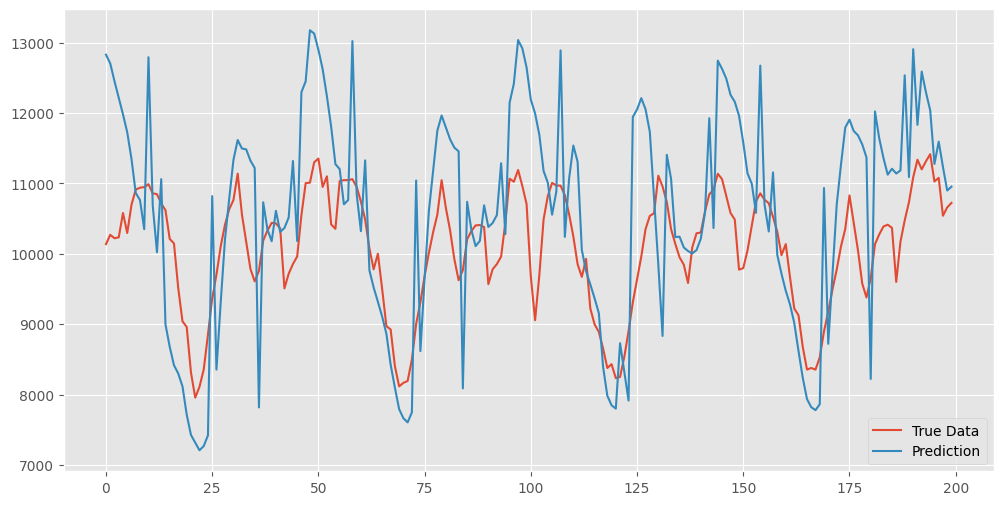

In [ ]:
fig = plt.figure(facecolor='white', figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(pred[-200:], label='True Data')
plt.plot(out[-200:], label='Prediction')
plt.legend()
plt.show()

In [ ]:
##GRU Model

In [ ]:
import torch
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size, 40)
        self.fc2 = nn.Linear(40, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        h_out, _ = self.gru(x, h0)
        h_out = h_out[:, -1, :]  # Take the final hidden state from the last time step
        
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, forecast_window):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = forecast_window
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -self.output_seq:, :])  # select the last 48 time steps and pass through the fully connected layer
        
        return out


In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

forecast_window = 6
input_size = 1
num_layers = 2
output_size = 1
hidden_size = 100
model = RNNModel(input_size, hidden_size, output_size, num_layers,forecast_window)
criterion = torch.nn.MSELoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
early_stopping_patience = 150
early_stopping_counter = 0

train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    
  model.train()

  for i , (input, output) in enumerate(training_data_load):
    input = input.to(device)
    output = output.to(device)
    optimizer.zero_grad()

    pred = model(input)
    loss_tr = criterion(output, pred)

    loss_tr.backward()

    optimizer.step()

  train_loss.append(loss_tr.item())

  model.eval()      
  with torch.no_grad():
    
    for i , (input, output) in enumerate(validation_data_load):
      input = input.to(device)
      output = output.to(device)

      pred = model(input)
      loss_val = criterion(output, pred)

    val_loss.append(loss_val.item())

    print(f'epoch {epoch} -->  train loss :{loss_tr.item()} , val loss : {loss_val.item()}')


epoch 0 -->  train loss :0.9868074059486389 , val loss : 1.209489107131958
epoch 1 -->  train loss :0.924084484577179 , val loss : 1.1545052528381348
epoch 2 -->  train loss :0.9130269289016724 , val loss : 1.1326510906219482
epoch 3 -->  train loss :0.9054173827171326 , val loss : 1.1213548183441162
epoch 4 -->  train loss :0.8984295725822449 , val loss : 1.1140166521072388
epoch 5 -->  train loss :0.8920198082923889 , val loss : 1.1078531742095947
epoch 6 -->  train loss :0.8855321407318115 , val loss : 1.1014307737350464
epoch 7 -->  train loss :0.8739153742790222 , val loss : 1.09190034866333
epoch 8 -->  train loss :0.817528247833252 , val loss : 1.1018041372299194
epoch 9 -->  train loss :0.7569359540939331 , val loss : 1.0704790353775024
epoch 10 -->  train loss :0.6842747330665588 , val loss : 1.0452345609664917
epoch 11 -->  train loss :0.6526903510093689 , val loss : 0.9413244724273682
epoch 12 -->  train loss :0.6416844725608826 , val loss : 0.8754782676696777
epoch 13 -->  

Text(0, 0.5, 'Loss')

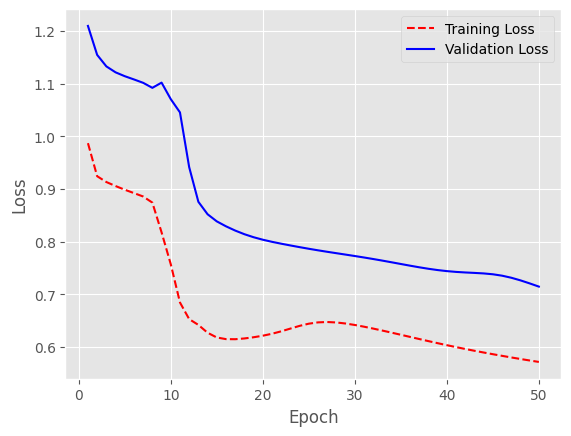

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import tqdm
plt.style.use('ggplot')
#from torchmetrics import MeanAbsolutePercentageError
  # visualization
  #  Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.clf()
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss','Validation Loss']) #, ['test Loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig(plots_file)

In [ ]:
#RMSE MAPE
def RMSE(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))

def MAPE(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets)*100)

In [ ]:
for i , (input, output) in enumerate(validation_data_load):
  input = input.to(device)
  output = output.to(device)

In [ ]:
#for test set
RMSE_result_test=[]
MAPE_result_test=[]

model.to(device)
model.eval()
with torch.no_grad():
  for i, (input ,output) in enumerate(validation_data_load):   # validation_dataloader

    
      input=input.to(device)
      output=output.to(device)
     

      prediction = model(input)

      #use inverse of scaler that we used for normalization for both y_true and prediction
      prediction=scaler_E.inverse_transform(prediction.detach().cpu().numpy().squeeze(-1))
      prediction=torch.tensor(prediction)
      prediction=prediction.unsqueeze(-1).to(device)

      output=scaler_E.inverse_transform(output.detach().cpu().numpy().squeeze(-1))
      output=torch.tensor(output)
      output=output.unsqueeze(-1).to(device)

      #loss_test = torch.sqrt(criterion(tgt_y, prediction))
      RMSE_test = RMSE(prediction,output)
      MAPE_test = MAPE(prediction,output)

      RMSE_result_test.append(RMSE_test.item())
      MAPE_result_test.append(MAPE_test.item())

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

RMSE_avg=Average(RMSE_result_test)
MAPE_avg= Average(MAPE_result_test)
print('The mean square error is: %f' % RMSE_avg)
print('MAPE is: %f' % MAPE_avg)

The mean square error is: 987.282294
MAPE is: 8.522661


In [ ]:
predictions=np.array(prediction.detach().cpu().numpy())
outputs = np.array(output.detach().cpu().numpy())
pred = predictions[:,-1,:]
out = outputs[:,-1,:]

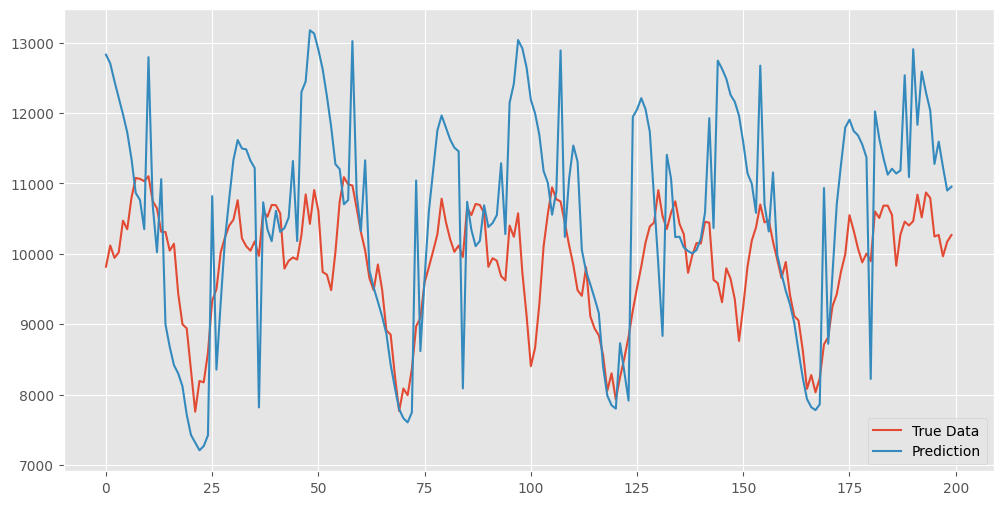

In [ ]:
fig = plt.figure(facecolor='white', figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(pred[-200:], label='True Data')
plt.plot(out[-200:], label='Prediction')
plt.legend()
plt.show()